In [46]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import preprocessing
from sklearn import discriminant_analysis as da
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import matplotlib.lines as mlines

# Excercise 10 Preditions from Weekly Data Set
## A: Descriptive Tables and Figures

In [2]:
weekly = pd.read_csv('../data/Weekly.csv', index_col = 0)

In [3]:
weekly.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
1,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
2,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
3,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
4,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
5,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


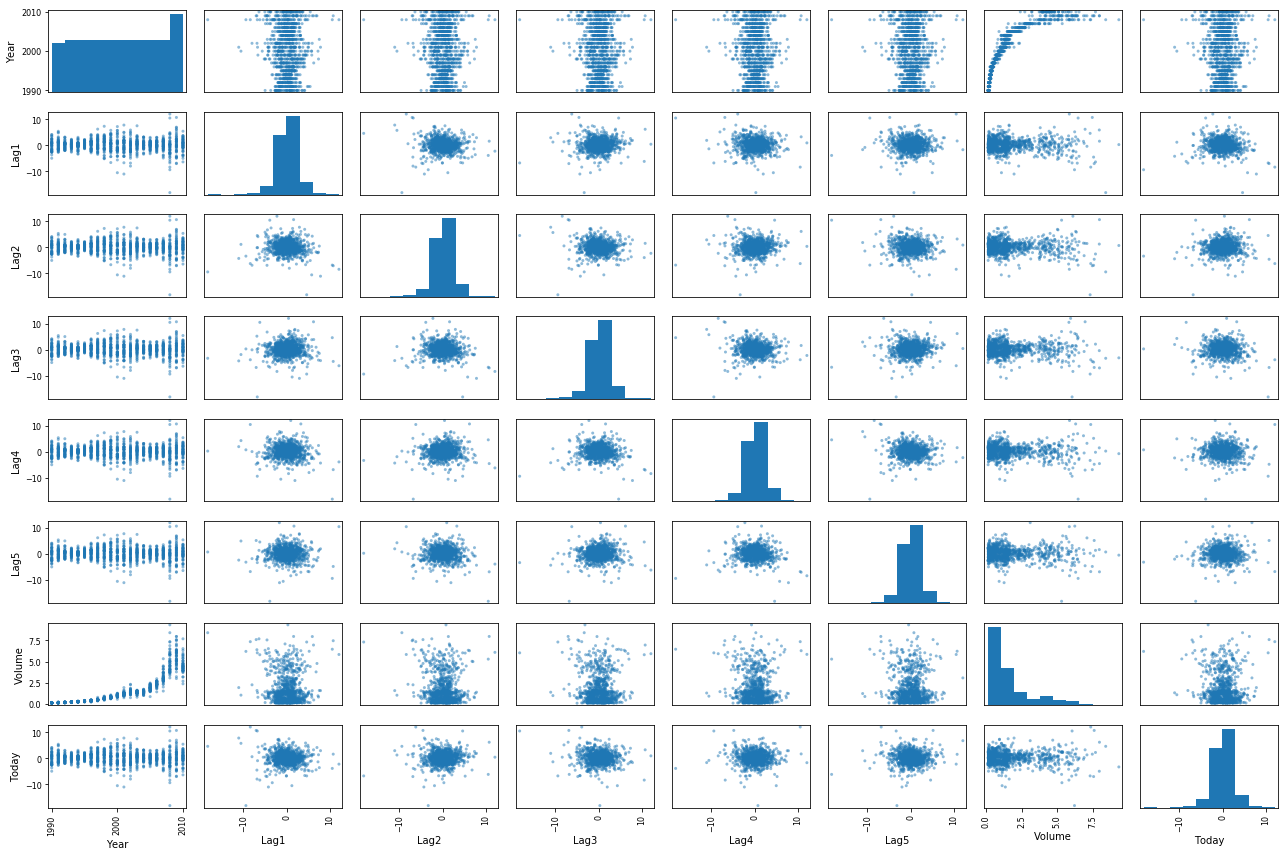

In [4]:
pd.plotting.scatter_matrix(weekly)
plt.tight_layout(rect = [0,0,3,3])

In [5]:
weekly.corr()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,-0.032289,-0.033390,-0.030006,-0.031128,-0.030519,0.841942,-0.032460
Lag1,-0.032289,1.000000,-0.074853,0.058636,-0.071274,-0.008183,-0.064951,-0.075032
Lag2,-0.033390,-0.074853,1.000000,-0.075721,0.058382,-0.072499,-0.085513,0.059167
Lag3,-0.030006,0.058636,-0.075721,1.000000,-0.075396,0.060657,-0.069288,-0.071244
Lag4,-0.031128,-0.071274,0.058382,-0.075396,1.000000,-0.075675,-0.061075,-0.007826
Lag5,-0.030519,-0.008183,-0.072499,0.060657,-0.075675,1.000000,-0.058517,0.011013
Volume,0.841942,-0.064951,-0.085513,-0.069288,-0.061075,-0.058517,1.000000,-0.033078
Today,-0.032460,-0.075032,0.059167,-0.071244,-0.007826,0.011013,-0.033078,1.000000


## B - D: Logistic Regression

In [6]:
weekly = weekly.join(pd.get_dummies(weekly['Direction'], prefix = 'Direction'))

In [7]:
wk_fit_1 = sm.Logit(weekly.Direction_Up, 
            sm.add_constant(weekly.loc[:,['Lag1','Lag2','Lag3','Lag4','Lag5','Volume']])).fit()

print(wk_fit_1.summary2())

Optimization terminated successfully.
         Current function value: 1.925080
         Iterations 4
                         Results: Logit
Model:              Logit            No. Iterations:   4.0000   
Dependent Variable: Direction_Up     Pseudo R-squared: -4.895   
Date:               2017-12-15 14:00 AIC:              4206.8236
No. Observations:   1089             BIC:              4241.7747
Df Model:           6                Log-Likelihood:   -2096.4  
Df Residuals:       1082             LL-Null:          -355.61  
Converged:          1.0000           Scale:            1.0000   
------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025   0.975]
------------------------------------------------------------------
const      0.2669     0.0859    3.1056   0.0019    0.0984   0.4353
Lag1      -0.0413     0.0264   -1.5626   0.1181   -0.0930   0.0105
Lag2       0.0584     0.0269    2.1754   0.0296    0.0058   0.1111
L

In [8]:
print(wk_fit_1.pred_table())

[[  54.  430.]
 [  48.  557.]]


In [9]:
wk_train = weekly[weekly.Year < 2009]

wk_test = weekly[weekly.Year > 2008]

wk_fit_2 = sm.Logit(weekly.Direction_Up, sm.add_constant(weekly.Lag2)).fit()

print(wk_fit_2.summary2())

Optimization terminated successfully.
         Current function value: 1.095346
         Iterations 4
                         Results: Logit
Model:              Logit            No. Iterations:   4.0000   
Dependent Variable: Direction_Up     Pseudo R-squared: -2.354   
Date:               2017-12-15 14:00 AIC:              2389.6626
No. Observations:   1089             BIC:              2399.6486
Df Model:           1                Log-Likelihood:   -1192.8  
Df Residuals:       1087             LL-Null:          -355.61  
Converged:          1.0000           Scale:            1.0000   
-------------------------------------------------------------------
         Coef.     Std.Err.      z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const    0.2147      0.0612    3.5072    0.0005    0.0947    0.3347
Lag2     0.0628      0.0264    2.3818    0.0172    0.0111    0.1145



In [10]:
pred_wk_2 = wk_fit_2.predict(sm.add_constant(wk_test.Lag2))

weekly_LR_out = pred_wk_2.to_frame()

weekly_LR_out.columns = ['Percent_Likelihood']

weekly_LR_out['Up_Pred'] = [int(x) for x in weekly_LR_out.Percent_Likelihood > 0.5]

weekly_LR_out['True_Value'] = wk_test.Direction_Up

weekly_LR_out['Pred_is_Correct'] = [int(x) for x in  weekly_LR_out.True_Value == weekly_LR_out.Up_Pred]

print(pd.crosstab(weekly_LR_out['Up_Pred'], weekly_LR_out['True_Value']))

print(np.mean(weekly_LR_out.Pred_is_Correct))

True_Value   0   1
Up_Pred           
0            9   5
1           34  56
0.625


## E: LDA

In [11]:
wk_lda = da.LinearDiscriminantAnalysis()
wk_lda.fit(wk_train.loc[:,['Lag2']], y = wk_train.Direction_Up)

wk_lda_pred_a = wk_lda.predict(wk_test.loc[:,['Lag2']])

wk_lda_pred = pd.DataFrame(index = wk_test.index, columns = ['Up_Pred'], data = wk_lda_pred_a)

wk_lda_pred['True_Up'] = wk_test.Direction_Up

wk_lda_pred['Pred_is_Corr'] = [int(x) for x in wk_lda_pred.Up_Pred == wk_lda_pred.True_Up]

print(pd.crosstab(wk_lda_pred['True_Up'], wk_lda_pred['Up_Pred']))

print(np.mean(wk_lda_pred.Pred_is_Corr))

Up_Pred  0   1
True_Up       
0        9  34
1        5  56
0.625


## F: QDA

In [12]:
wk_qda = da.QuadraticDiscriminantAnalysis()
wk_qda.fit(wk_train.loc[:,['Lag2']], wk_train.Direction_Up)

wk_qda_pred_a = wk_qda.predict(wk_test.loc[:,['Lag2']])

wk_qda_pred = pd.DataFrame(index = wk_test.index, columns= ['Up_Pred'], data = wk_qda_pred_a)

wk_qda_pred['True_Up'] = wk_test.Direction_Up

wk_qda_pred['Pred_is_Corr'] = [int(x) for x in wk_qda_pred.Up_Pred == wk_qda_pred.True_Up]

print(pd.crosstab(wk_qda_pred['True_Up'], wk_qda_pred['Up_Pred']))

print(np.mean(wk_qda_pred.Pred_is_Corr))

Up_Pred   1
True_Up    
0        43
1        61
0.5865384615384616


## G: KNN with K = 1 

In [13]:
wk_knn = neighbors.KNeighborsClassifier(n_neighbors=1)
wk_knn.fit(wk_train.loc[:,['Lag2']], wk_train.Direction_Up)

wk_knn_pred = pd.DataFrame(index = wk_test.index, columns=['Up_Pred'], 
                           data = wk_knn.predict(wk_test.loc[:,['Lag2']]))

wk_knn_pred['True_Up'] = wk_test.Direction_Up

print(pd.crosstab(wk_knn_pred['True_Up'], wk_knn_pred['Up_Pred']))

print(wk_knn.score(wk_test.loc[:,['Lag2']], wk_test.Direction_Up))

Up_Pred   0   1
True_Up        
0        21  22
1        31  30
0.490384615385


## I: Play around with hyper-parameters

In [14]:
cv_knn = neighbors.KNeighborsClassifier()

param_grid = [
    {'n_neighbors': range(1,200, 10)}
]

knn_grid = GridSearchCV(cv_knn, param_grid = param_grid)
knn_grid.fit(wk_train.loc[:,['Lag2']], wk_train.Direction_Up)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_neighbors': range(1, 200, 10)}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

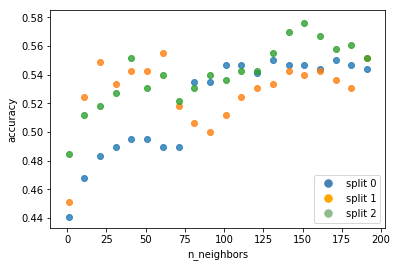

In [15]:
sp0 = sns.regplot(np.array(range(1, 200, 10)), knn_grid.cv_results_['split0_test_score'], fit_reg = False, label = 'split0').set(xlabel = 'n_neighbors', ylabel = 'accuracy')
sp1 = sns.regplot(np.array(range(1, 200, 10)), knn_grid.cv_results_['split1_test_score'], fit_reg = False, label = 'split1')
sp2 = sns.regplot(np.array(range(1, 200, 10)), knn_grid.cv_results_['split2_test_score'], fit_reg = False, label = 'split2')

blue_line = mlines.Line2D([], [], color='steelblue', marker='.',
                          markersize=15, label='split 0', linestyle='')
orange_line = mlines.Line2D([], [], color='orange', marker='.',
                          markersize=15, label='split 1', linestyle='')
green_line = mlines.Line2D([], [], color='darkseagreen', marker='.',
                          markersize=15, label='split 2', linestyle='')

plt.legend(handles=[blue_line, orange_line, green_line])

#plt.legend(handles = [sp0, sp1, sp2], labels = ['split0','split1','split2'], loc = 4)

plt.show()

# Exercise 11

In [18]:
auto = pd.read_csv('../data/Auto.csv')

In [22]:
auto['mpg01'] = [int(x) for x in (auto['mpg'] > np.median(auto['mpg']))]

In [23]:
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg01
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu,0
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320,0
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite,0
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst,0
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino,0


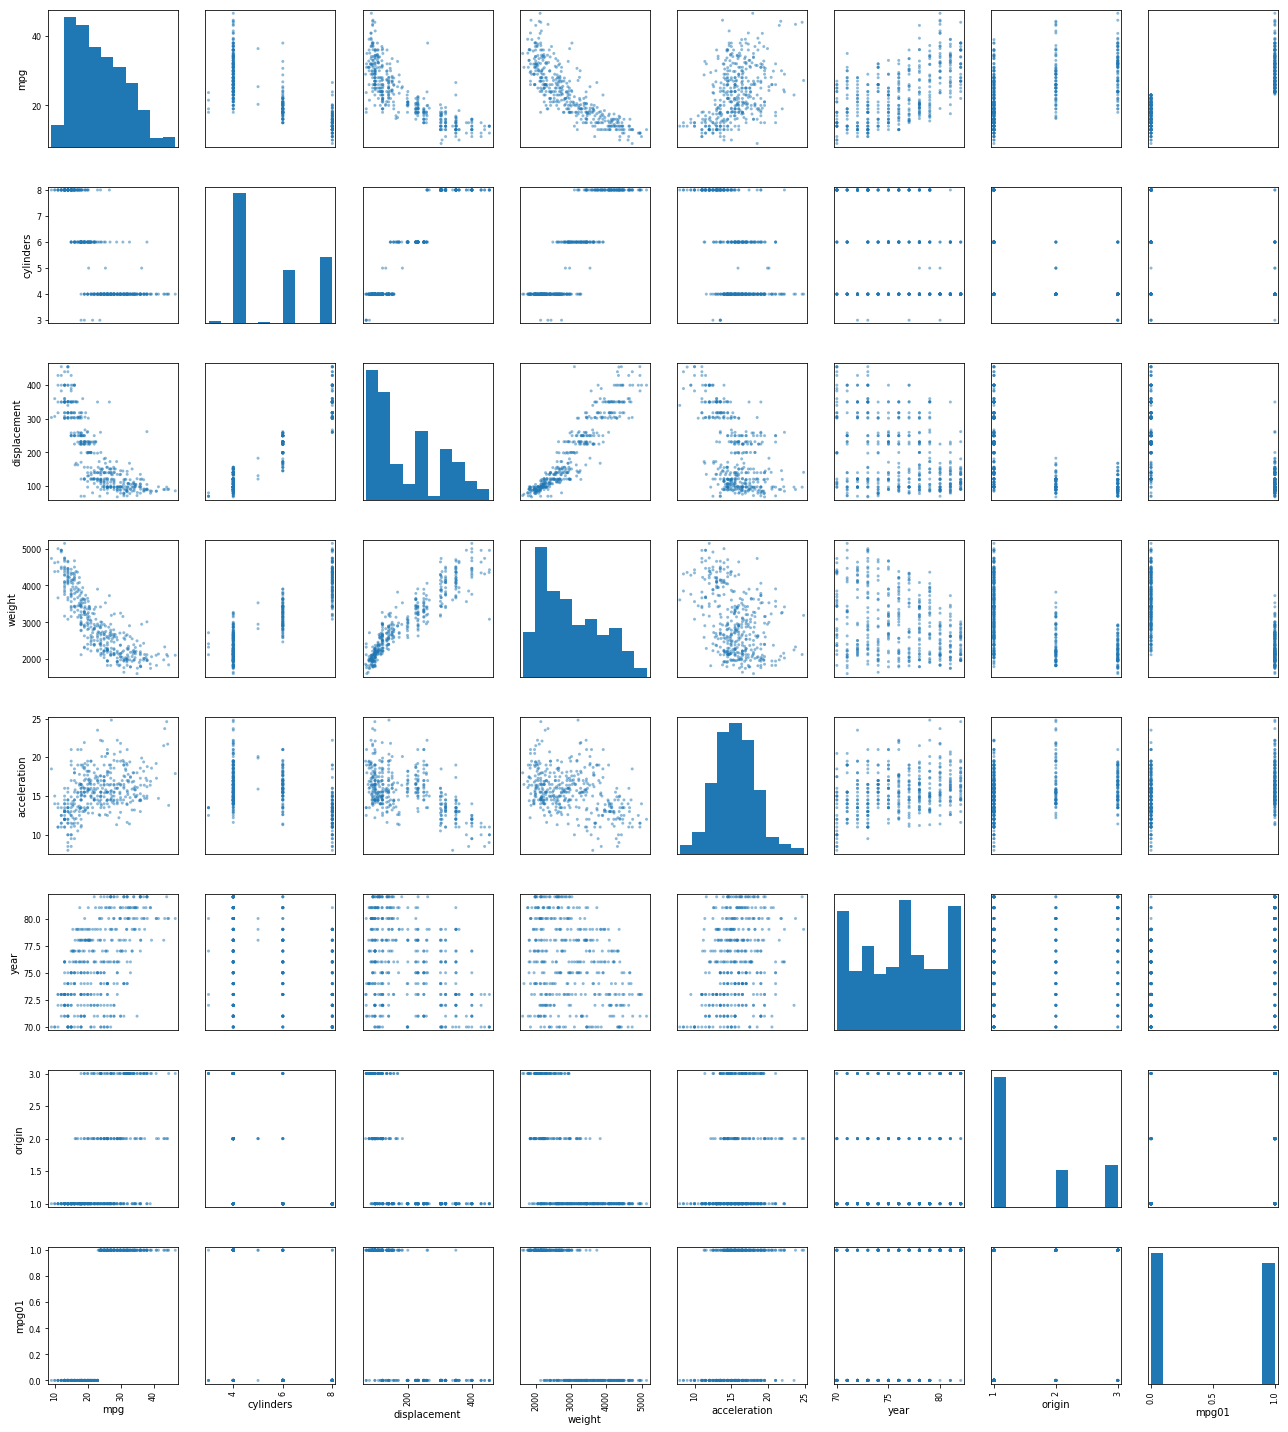

In [27]:
pd.plotting.scatter_matrix(auto)
plt.tight_layout(rect = [0,0,3,5])

In [28]:
auto.corr()

,mpg,cylinders,displacement,weight,acceleration,year,origin,mpg01
mpg,1.000000,-0.776260,-0.804443,-0.831739,0.422297,0.581469,0.563698,0.838239
cylinders,-0.776260,1.000000,0.950920,0.897017,-0.504061,-0.346717,-0.564972,-0.740327
displacement,-0.804443,0.950920,1.000000,0.933104,-0.544162,-0.369804,-0.610664,-0.738607
weight,-0.831739,0.897017,0.933104,1.000000,-0.419502,-0.307900,-0.581265,-0.745734
acceleration,0.422297,-0.504061,-0.544162,-0.419502,1.000000,0.282901,0.210084,0.322629
year,0.581469,-0.346717,-0.369804,-0.307900,0.282901,1.000000,0.184314,0.454108
origin,0.563698,-0.564972,-0.610664,-0.581265,0.210084,0.184314,1.000000,0.511393
mpg01,0.838239,-0.740327,-0.738607,-0.745734,0.322629,0.454108,0.511393,1.000000


Text(0.5,0.98,'mpg for a few variables')

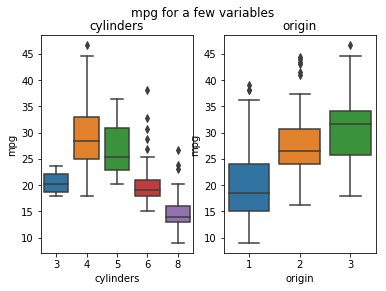

In [43]:
f, ax = plt.subplots(1,2)
sns.boxplot(auto['cylinders'], auto['mpg'], ax = ax[0]).set_title('cylinders')
sns.boxplot(auto['origin'], auto['mpg'], ax = ax[1]).set_title('origin')
f.suptitle('mpg for a few variables')


In [33]:
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg01
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu,0
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320,0
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite,0
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst,0
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino,0


In [54]:
auto_train, auto_test = train_test_split(auto, test_size = 0.25)

In [58]:
auto_lda = da.LinearDiscriminantAnalysis()
auto_lda.fit(auto_train.loc[:,['cylinders', 'displacement', 'weight']], 
                                         auto_train.mpg01)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [60]:
auto_lda.score(auto_test.loc[:,['cylinders', 'displacement', 'weight']],
              auto_test.mpg01)

0.85999999999999999

In [61]:
auto_qda = da.QuadraticDiscriminantAnalysis()
auto_qda.fit(auto_train.loc[:,['cylinders', 'displacement', 'weight']], 
                                         auto_train.mpg01)
auto_qda.score(auto_test.loc[:,['cylinders', 'displacement', 'weight']],
              auto_test.mpg01)

0.85999999999999999

## f: logistic regression